# Analysing 4D-STEM dataset

In [1]:
%matplotlib nbagg

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from ncempy.io import dm
from pacbedclient import query
from skimage import transform

import concurrent.futures

<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [3]:
# Files, which should be loaded
file_4d = 'D:\\TEM\\Titan\\300kV_STO\\28072022\\SI data (27)\\000_Diffraction SI.dm4'
file_haadf = 'D:\\TEM\\Titan\\300kV_STO\\28072022\\SI data (27)\\000_HAADF Image (SI Survey).dm4'
# Coordinates of the SI in the survey image, where the 4D is recorded (taken from GMS) --> Plotting the correct part of the corresponding haadf signal
x_si = 188 # px
y_si = 157 # px
width = 710 # px
height = 710 # px

In [4]:
pool = concurrent.futures.ThreadPoolExecutor(max_workers=4)

In [5]:
# Load pacbed map - generated by subpixel scanning
im=dm.dmReader(file_4d)
pacbed_map = im['data']

In [6]:
# Analysing pacbed
def do_query(i):
    print(f"querying {i}...")
    i_x, i_y = np.unravel_index(i, pacbed_map.shape[-2:], order='C')
    result = query(
        image_array=pacbed_map[:, :, i_x, i_y],
        crystal_structure='Strontium Titanate',
        acceleration_voltage=300000,
        convergence_angle=19.6,
        zone_u=0, zone_v=0, zone_w=1,
        host='localhost',
        port='8230'
    )
    print(f"{i} done")
    return result

# Heatmap from https://github.com/durandtibo/heatmap
def add(image, heat_map, alpha=0.6, display=False, save=None, cmap='viridis', axis='on', verbose=False):

    height = image.shape[0]
    width = image.shape[1]

    # resize heat map
    heat_map_resized = transform.resize(heat_map, (height, width))

    # display
    plt.figure()
    plt.imshow(image, cmap = 'gray')
    c_plot = plt.imshow(heat_map_resized, alpha=alpha, cmap=cmap)
    plt.axis(axis)
    color_bar = plt.colorbar(c_plot, ax = plt.gca())
    color_bar.set_label('Thickness / A')
    color_bar.set_alpha(1)
    color_bar.draw_all()

    if display:
        plt.show()

    if save is not None:
        if verbose:
            print('save image: ' + save)
        plt.savefig(save, bbox_inches='tight', pad_inches=0)
        
    return 

In [7]:
%%time
results = list(pool.map(do_query, range(pacbed_map.shape[-1]* pacbed_map.shape[-2])))

querying 0...
querying 1...
querying 2...
querying 3...
0 done
querying 4...
2 done
querying 5...
1 done
querying 6...
3 done
querying 7...
4 done
querying 8...
5 done
querying 9...
6 done
querying 10...
7 done
querying 11...
9 done
querying 12...
8 done
querying 13...
10 done
querying 14...
11 done
querying 15...
12 done
querying 16...
13 done
querying 17...
15 done
querying 18...
14 done
querying 19...
16 done
querying 20...
17 done
querying 21...
18 done
querying 22...
19 done
querying 23...
20 done
querying 24...
21 done
querying 25...
22 done
querying 26...
23 done
querying 27...
24 done
querying 28...
25 done
querying 29...
26 done
querying 30...
27 done
querying 31...
28 done
querying 32...
29 done
querying 33...
30 done
querying 34...
31 done
querying 35...
33 done
querying 36...
32 done
querying 37...
35 done
querying 38...
34 done
querying 39...
36 done
querying 40...
37 done
querying 41...
39 done
querying 42...
38 done
querying 43...
40 done
querying 44...
42 done
querying 

<IPython.core.display.Javascript object>


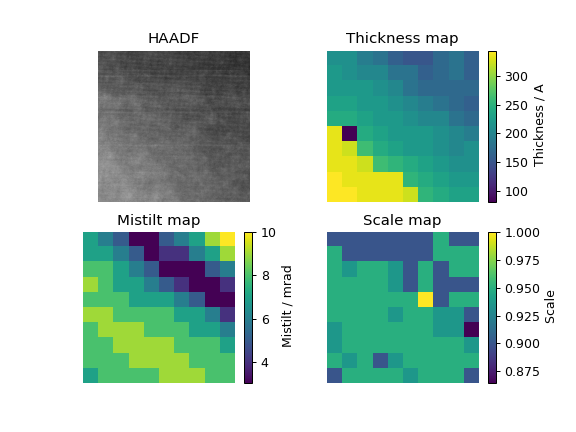

In [8]:
# Load corresponding HAADF image
im=dm.dmReader(file_haadf)
# Select ROI (indeces extracted from GMS)
haadf_map = im['data'][y_si:y_si+height, x_si:x_si+width]


# Reshape thickness map
thickness_map = [r['thickness'] for r in results]
thickness_map = np.array(thickness_map).reshape(pacbed_map.shape[-2:])
# Reshape mistilt map
mistilt_map = [r['mistilt'] for r in results]
mistilt_map = np.array(mistilt_map).reshape(pacbed_map.shape[-2:])
# Reshape scale map
scale_map = [r['scale'] for r in results]
scale_map = np.array(scale_map).reshape(pacbed_map.shape[-2:])

# Plotting results
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2)

im_haadf = ax1.imshow(haadf_map, cmap = 'gray')
ax1.axis('off')
ax1.set_title('HAADF')

im_thick = ax2.imshow(thickness_map/10)
ax2.axis('off')
ax2.set_title('Thickness map')
c_bar2 = fig.colorbar(im_thick, ax = ax2)
c_bar2.set_label(' Thickness / nm')

im_mistilt = ax3.imshow(mistilt_map)
ax3.axis('off')
ax3.set_title('Mistilt map')
c_bar3 = fig.colorbar(im_mistilt, ax = ax3)
c_bar3.set_label(' Mistilt / mrad')

im_scale = ax4.imshow(scale_map)
ax4.axis('off')
ax4.set_title('Scale map')
c_bar4 = fig.colorbar(im_scale, ax = ax4)
c_bar4.set_label(' Scale')

<IPython.core.display.Javascript object>


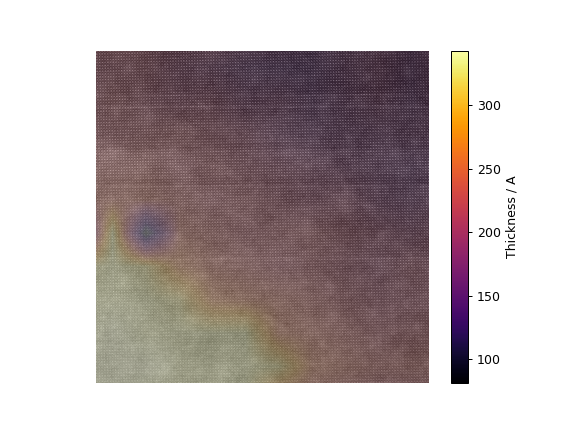

In [10]:
# Generating heatmap (thickness map overlayed to the haadf image)
add(haadf_map, thickness_map, alpha=0.2, display=True, save=None, cmap='inferno', axis='off', verbose=False)

<IPython.core.display.Javascript object>


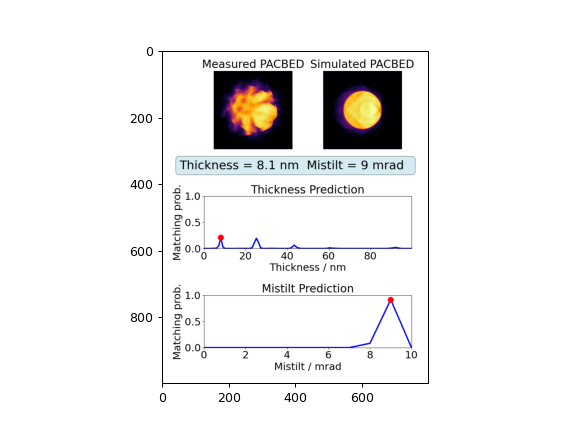

<IPython.core.display.Javascript object>


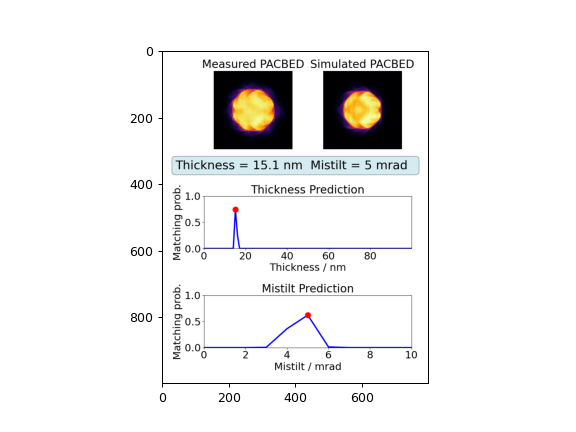

<IPython.core.display.Javascript object>


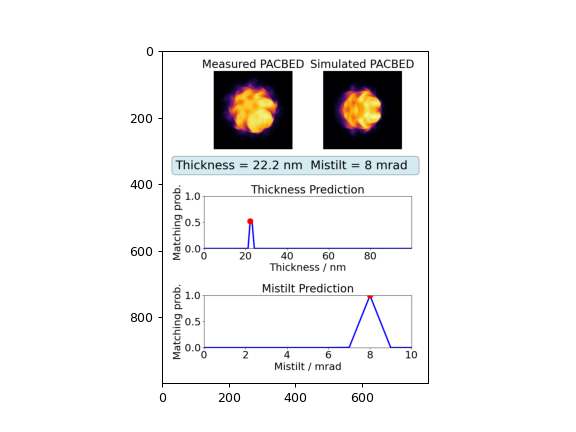

<IPython.core.display.Javascript object>


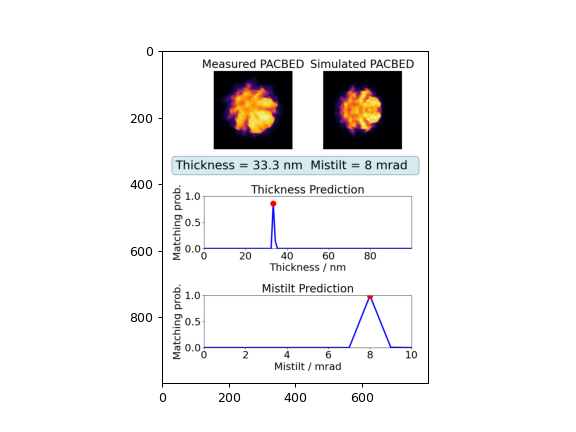

<IPython.core.display.Javascript object>


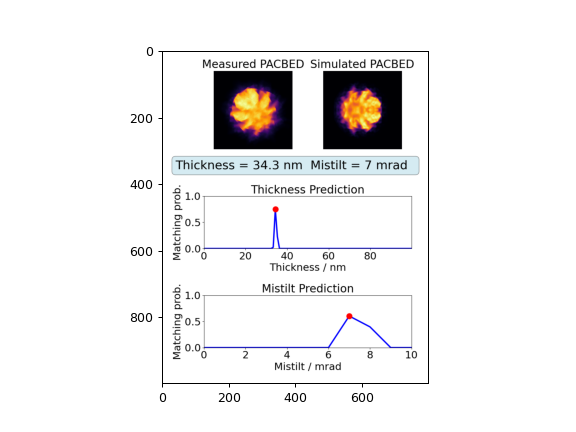

In [9]:
# Observe validation image

outlier_indices = [5*10 + 1, 5, 20, 70, 90]

for i in outlier_indices:
    fig, axes = plt.subplots()
    axes.imshow(results[i]['validation'])